In [1]:
import os
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

np.random.seed(0)

In [2]:
df = pd.read_csv("data/adult.csv")
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [3]:
df.replace('?', np.nan, inplace=True)

In [4]:
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_widgets()
# profile.to_file("lab5_EDA_report.html")

In [5]:
from sklearn.preprocessing import OneHotEncoder


def encode_cat_cols(train_df: pd.DataFrame, columns_to_encode: list):
    """
    Converts categorical column(s) in the DataFrames to one-hot encoded variables using sklearn's OneHotEncoder.

    Args:
        train_df (pd.DataFrame): The training DataFrame containing the categorical columns to encode.
        columns_to_encode (list): A list of strings representing the names of the
                                  categorical columns to be one-hot encoded.

    Returns:
        pd.DataFrame: DataFrame with the original categorical columns replaced by
                                     their one-hot encoded counterparts.
    """
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output  =False, dtype=int)
    encoder.fit(train_df[columns_to_encode])
    
    train_encoded_array = encoder.transform(train_df[columns_to_encode])
    train_encoded = pd.DataFrame(train_encoded_array, columns=encoder.get_feature_names_out(columns_to_encode))
    train_df = train_df.drop(columns=columns_to_encode).reset_index(drop=True)
    train_df = pd.concat([train_df, train_encoded], axis=1)
    print("✅columns encoded")
    return train_df

In [6]:
CAT_COLS = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
NUM_COLS = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

In [7]:
df = encode_cat_cols(df, columns_to_encode=CAT_COLS)

✅columns encoded


In [8]:
y = df['income'].values
y = [0 if y_i == '<=50K' else 1 for y_i in y]

In [9]:
COLUMNS_TO_REMOVE = ['income', 'education']

In [10]:
X = df[[col for col in df.columns if col not in COLUMNS_TO_REMOVE]].values

In [45]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import make_scorer
SCORING = {'accuracy': make_scorer(accuracy_score),
           'f1_binary': make_scorer(f1_score, average="binary")
           }

# SCORING = {
#     'accuracy': 'accuracy',
#     'f1_binary': 'f1_binary'
# }

def run_cross_validation(model, X, y, cv=5, scoring=SCORING):
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
    return scores

models = {
    'Random Forest': RandomForestClassifier(),
    'Hist. Gradient Boosting': HistGradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}


results = {
    "Model": [],
    "F1 Binary (mean)": [],
    "F1 Binary (std)": [],
    "Accuracy (mean)": [],
    "Accuracy (std)": []
}

f1_binary_scores = []
accuracy_scores = []

# Run cross-validation for each model
for model_name, model in models.items():
    scores = run_cross_validation(model, X, y)
    f1_binary_scores.append(scores["test_f1_binary"])
    accuracy_scores.append(scores["test_accuracy"])
    results["Model"].append(model_name)
    results["F1 Binary (mean)"].append(np.mean(scores['test_f1_binary']))
    results["F1 Binary (std)"].append(np.std(scores['test_f1_binary']))
    results["Accuracy (mean)"].append(np.mean(scores['test_accuracy']))
    results["Accuracy (std)"].append(np.std(scores['test_accuracy']))


[LightGBM] [Info] Number of positive: 6272, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 581
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240786 -> initscore=-1.148374
[LightGBM] [Info] Start training from score -1.148374
[LightGBM] [Info] Number of positive: 6273, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 79
[LightGBM] [Info] [bin

In [46]:
from IPython.display import display, Markdown

df_results = pd.DataFrame(data=results).round(3)
display(Markdown(df_results.to_markdown()))

|    | Model                   |   F1 Binary (mean) |   F1 Binary (std) |   Accuracy (mean) |   Accuracy (std) |
|---:|:------------------------|-------------------:|------------------:|------------------:|-----------------:|
|  0 | Random Forest           |              0.543 |             0.09  |             0.808 |            0.022 |
|  1 | Hist. Gradient Boosting |              0.551 |             0.098 |             0.81  |            0.03  |
|  2 | XGBoost                 |              0.56  |             0.11  |             0.818 |            0.025 |
|  3 | LightGBM                |              0.553 |             0.097 |             0.81  |            0.033 |
|  4 | CatBoost                |              0.577 |             0.058 |             0.82  |            0.02  |

/var/folders/cw/3q5ykvvj1031m_07d0vbll1m0000gr/T/ipykernel_29042/2268942077.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/var/folders/cw/3q5ykvvj1031m_07d0vbll1m0000gr/T/ipykernel_29042/2268942077.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


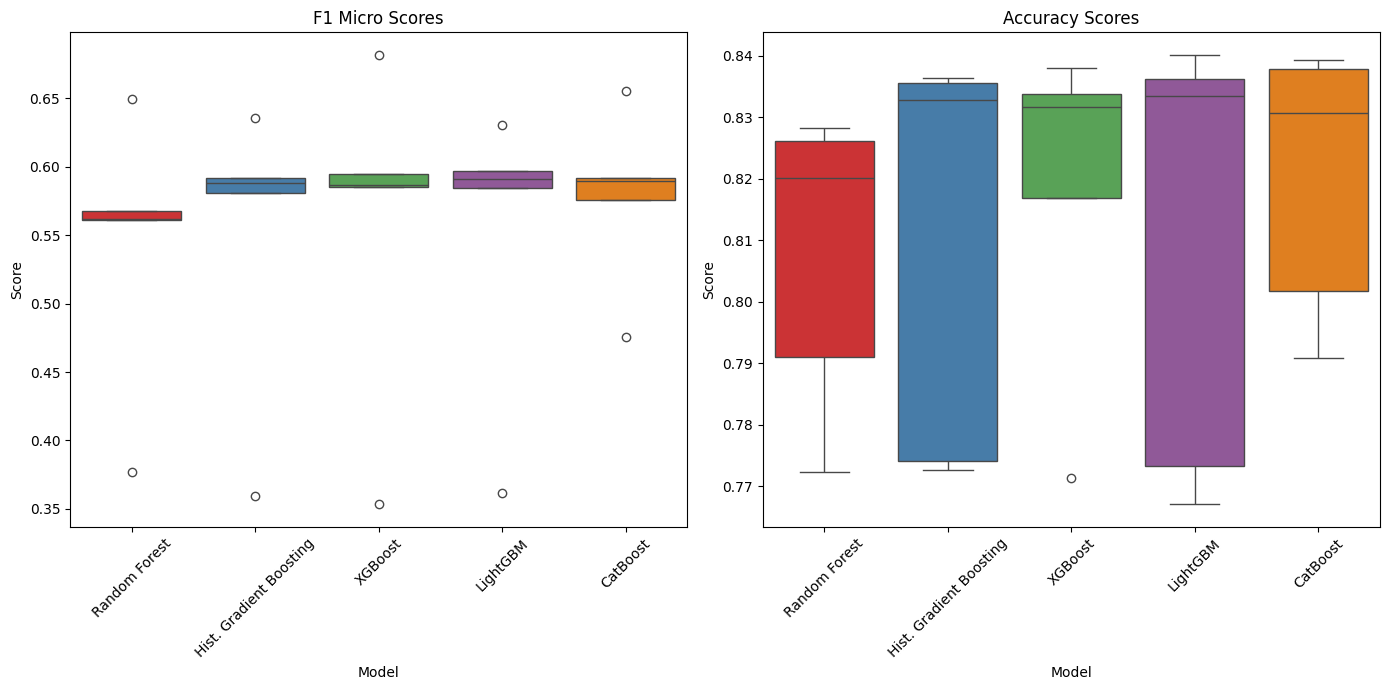

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

f1_micro_df = pd.DataFrame(f1_binary_scores).T
f1_micro_df.columns = models.keys()
f1_micro_df = f1_micro_df.melt(var_name='Model', value_name='F1 Micro Score')

accuracy_df = pd.DataFrame(accuracy_scores).T
accuracy_df.columns = models.keys()
accuracy_df = accuracy_df.melt(var_name='Model', value_name='Accuracy Score')

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

sns.boxplot(x='Model', y='F1 Micro Score', data=f1_micro_df, ax=axes[0], hue='Model', legend=False, palette="Set1")
axes[0].set_title('F1 Micro Scores')
axes[0].set_ylabel('Score')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.boxplot(x='Model', y='Accuracy Score', data=accuracy_df, ax=axes[1], hue='Model', legend=False, palette="Set1")
axes[1].set_title('Accuracy Scores')
axes[1].set_ylabel('Score')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### optymalizacja hiepraparametrów dla ***XGBClassifier***

In [71]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.5, random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/Users/stefan/coding/pwr-ai/ml/ml-venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [72]:
display(Markdown("### Best parameters found for ***XGB Classifier***"))
md_str = ""
for param, value in best_params.items():
    md_str += f"- ***{param}***: **{value}**\n"
display(Markdown(md_str))

### Best parameters found for ***XGB Classifier***

- ***colsample_bytree***: **0.6**
- ***gamma***: **0**
- ***learning_rate***: **0.1**
- ***max_depth***: **5**
- ***n_estimators***: **200**


In [73]:
xgb_scores = run_cross_validation(best_model, X, y, cv=10)
display(Markdown(f'### ***F1 (mean)***: {np.mean(xgb_scores["test_f1_binary"]):.3f}'))
display(Markdown(f'### ***Accuracy***: {np.mean(xgb_scores["test_accuracy"]):.3f}'))

### ***F1 (mean)***: 0.560

### ***Accuracy***: 0.821

### optymalizacja hiepraparametrów dla ***HistGradientBoostingClassifier***

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier()
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_iter": [100, 200],
    "max_leaf_nodes": [31, 63],
    "max_depth": [None, 10],
    "min_samples_leaf": [1, 10],
    "l2_regularization": [0.0, 0.1],
    "max_bins": [255, 128],
    "categorical_features": [None],
    "random_state": [42]
}


grid_search = GridSearchCV(estimator=hgb, param_grid=param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [96]:
display(Markdown("### Best parameters found for ***XGB Classifier***"))
md_str = ""
for param, value in best_params.items():
    md_str += f"- ***{param}***: **{value}**\n"
display(Markdown(md_str))

### Best parameters found for ***XGB Classifier***

- ***categorical_features***: **None**
- ***l2_regularization***: **0.0**
- ***learning_rate***: **0.01**
- ***max_bins***: **255**
- ***max_depth***: **None**
- ***max_iter***: **200**
- ***max_leaf_nodes***: **63**
- ***min_samples_leaf***: **10**
- ***random_state***: **42**


In [97]:
hgbc_scores = run_cross_validation(best_model, X, y, cv=10)
display(Markdown(f'### ***F1 (mean)***: {np.mean(hgbc_scores["test_f1_binary"]):.3f}'))
display(Markdown(f'### ***Accuracy***: {np.mean(hgbc_scores["test_accuracy"]):.3f}'))

### ***F1 (mean)***: 0.569

### ***Accuracy***: 0.821

### ograniczenia monotoniczne (ang. *monotonic cosntraints*)

In [87]:
df.head()

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,income,workclass_Federal-gov,workclass_Local-gov,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,native.country_nan
0,90,77053,HS-grad,9,0,4356,40,<=50K,0,0,...,0,0,0,0,0,0,1,0,0,0
1,82,132870,HS-grad,9,0,4356,18,<=50K,0,0,...,0,0,0,0,0,0,1,0,0,0
2,66,186061,Some-college,10,0,4356,40,<=50K,0,0,...,0,0,0,0,0,0,1,0,0,0
3,54,140359,7th-8th,4,0,3900,40,<=50K,0,0,...,0,0,0,0,0,0,1,0,0,0
4,41,264663,Some-college,10,0,3900,40,<=50K,0,0,...,0,0,0,0,0,0,1,0,0,0


In [85]:
df['hours.per.week'][0:5]

0    40
1    18
2    40
3    40
4    40
Name: hours.per.week, dtype: int64

In [86]:
X[:,5][0:5]

array([40, 18, 40, 40, 40])

In [82]:
X.shape

(32561, 92)

In [83]:
mon_const = [0, 0, 0, 0, 0, 1] + [0] * 86
len(mon_const)

92

In [94]:
model_mc = HistGradientBoostingClassifier(
                l2_regularization=0.1,
                learning_rate=0.1,
                max_bins=255,
                max_depth=10,
                max_iter=100,
                max_leaf_nodes=31,
                min_samples_leaf=1,
                random_state=42,
                monotonic_cst=mon_const
        )

hgbc_scores = run_cross_validation(model_mc, X, y, cv=10)
display(Markdown(f'### ***F1 (mean)***: {np.mean(hgbc_scores["test_f1_binary"]):.5f}'))
display(Markdown(f'### ***Accuracy***: {np.mean(hgbc_scores["test_accuracy"]):.3f}'))

### ***F1 (mean)***: 0.54554

### ***Accuracy***: 0.810

In [92]:
model_mc = HistGradientBoostingClassifier(
                monotonic_cst=mon_const,
                random_state=42
        )

hgbc_scores = run_cross_validation(model_mc, X, y, cv=10)
display(Markdown(f'### ***F1 (mean)***: {np.mean(hgbc_scores["test_f1_binary"]):.5f}'))
display(Markdown(f'### ***Accuracy***: {np.mean(hgbc_scores["test_accuracy"]):.3f}'))

### ***F1 (mean)***: 0.55062

### ***Accuracy***: 0.811

In [93]:
model_mc = HistGradientBoostingClassifier(random_state=42)

hgbc_scores = run_cross_validation(model_mc, X, y, cv=10)
display(Markdown(f'### ***F1 (mean)***: {np.mean(hgbc_scores["test_f1_binary"]):.5f}'))
display(Markdown(f'### ***Accuracy***: {np.mean(hgbc_scores["test_accuracy"]):.3f}'))

### ***F1 (mean)***: 0.55068

### ***Accuracy***: 0.810